In [1]:
import os
import pandas as pd, numpy as np, torch, time
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines # Import mlines for custom legend handles

# ---------------------------------------------------------------------------
# 1. Preprocessing helpers
# ---------------------------------------------------------------------------

class EarthquakePreprocessor:
    """
    Preprocesses raw earthquake catalog data into spatiotemporal cubes
    for ConvLSTM input.
    """
    def __init__(self, csv_path, start_date='1950-01-01', min_mag=3.0, # Changed default start_date
                 seq_len=7, pred_horizon=1):
        """
        Initializes the preprocessor with data parameters and grid/bin definitions.

        Args:
            csv_path (str): Path to the earthquake catalog CSV file.
            start_date (str): Start date for filtering earthquakes.
            min_mag (float): Minimum magnitude for filtering earthquakes.
            seq_len (int): Length of the input sequences for ConvLSTM.
            pred_horizon (int): Number of days to predict into the future.
        """
        self.csv_path = csv_path
        self.start_date = pd.to_datetime(start_date)
        self.min_mag    = min_mag
        self.seq_len    = seq_len
        self.pred_h     = pred_horizon
        # Southern-Calif grid & mag bins based on paper
        # Lat bins: 30 to 40 degrees with 6 edges (5 bins)
        self.lat_bins  = np.linspace(30, 40, 6)
        # Lon bins: -125 to -114 degrees with 21 edges (20 bins)
        self.lon_bins  = np.linspace(-125, -114, 21)
        # Mag bins: 3.0 to 5.0+ with 6 edges (5 bins)
        self.mag_bins  = [3.0,3.5,4.0,4.5,5.0,np.inf]

    def load(self):
        """
        Loads the earthquake catalog from CSV and filters it based on
        start date and minimum magnitude.
        """
        df = pd.read_csv(self.csv_path, parse_dates=['time'])
        df = df.dropna(subset=['time','latitude','longitude','magnitude'])
        df = df[df['magnitude'] >= self.min_mag]
        df = df[df['time'] >= self.start_date]
        df['date'] = df['time'].dt.floor('d')
        self.df = df.reset_index(drop=True)

    def _day_cube(self, day_df):
        """
        Converts a day's earthquake data into a spatiotemporal cube.

        Args:
            day_df (pd.DataFrame): DataFrame containing earthquakes for a single day.

        Returns:
            np.ndarray: A 3D numpy array (mag_bins, lat_bins, lon_bins)
                        representing the earthquake counts in each bin.
        """
        cube = np.zeros((len(self.mag_bins)-1, len(self.lat_bins)-1, len(self.lon_bins)-1), dtype=np.float32)
        if not day_df.empty:
            # Digitizing magnitude, latitude, and longitude into bins
            m = np.clip(np.digitize(day_df['magnitude'], self.mag_bins)-1, 0, len(self.mag_bins)-2)
            la = np.clip(np.digitize(day_df['latitude'], self.lat_bins)-1, 0, len(self.lat_bins)-2)
            lo = np.clip(np.digitize(day_df['longitude'], self.lon_bins)-1, 0, len(self.lon_bins)-2)
            # Populating the cube with earthquake counts
            for mi, lati, loni in zip(m, la, lo):
                cube[mi, lati, loni] += 1
        return cube

    def build_sequences(self):
        """
        Builds input-output sequences and corresponding target dates
        from the daily earthquake cubes.
        """
        days = pd.date_range(self.df['date'].min(), self.df['date'].max(), freq='D')
        self.daily_cubes = {}
        cubes = []
        # Create a cube for each day
        for date in days:
            cube = self._day_cube(self.df[self.df['date'] == date])
            self.daily_cubes[date] = cube
            cubes.append(cube)

        X, Y, T = [], [], []
        # Create sequences and corresponding target days
        for i in range(len(days) - self.seq_len - self.pred_h + 1):
            X.append(np.stack(cubes[i:i+self.seq_len], 0))
            Y.append(cubes[i+self.seq_len+self.pred_h-1])
            T.append(days[i+self.seq_len+self.pred_h-1])
        self.X, self.Y, self.T = map(np.array, [X, Y, T])

    def split(self, val_cutoff='1991-01-01', test_cutoff='2000-01-01'):
        """
        Splits the sequences into training, validation, and testing sets
        based on two time cutoffs.

        Args:
            val_cutoff (str): The date string for the training/validation split.
            test_cutoff (str): The date string for the validation/testing split.

        Returns:
            tuple: A tuple containing (train_X, train_Y), (val_X, val_Y),
                   and (test_X, test_Y) as numpy arrays.
        """
        val_cut = pd.Timestamp(val_cutoff)
        test_cut = pd.Timestamp(test_cutoff)

        train_idx = self.T < val_cut
        val_idx = (self.T >= val_cut) & (self.T < test_cut)
        test_idx = self.T >= test_cut

        return (self.X[train_idx], self.Y[train_idx]), \
               (self.X[val_idx], self.Y[val_idx]), \
               (self.X[test_idx], self.Y[test_idx])


class SeqDS(Dataset):
    """Custom Dataset for earthquake sequences."""
    def __init__(self,X,Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()
    def __len__(self): return len(self.X)
    def __getitem__(self,i): return self.X[i], self.Y[i]

# ---------------------------------------------------------------------------
# 2. ConvLSTM model (4x40 filters)
# ---------------------------------------------------------------------------
# Based on the ConvLSTM architecture described in the paper

def _conv(inC,outC,ks=3):
    """Helper function for 2D convolutional layer used within ConvLSTM cell."""
    # Convolutional layer for input-to-state and state-to-state transitions
    return nn.Conv2d(inC+outC,4*outC,ks,padding=ks//2,bias=True)

class CLSTMCell(nn.Module):
    """ConvLSTM Cell implementation."""
    def __init__(s,inC,hC):
        super().__init__(); s.hC=hC; s.conv=_conv(inC,hC)

    def forward(s,x,h,c):
        """
        Forward pass for the ConvLSTM cell.

        Args:
            x (torch.Tensor): Input tensor.
            h (torch.Tensor): Previous hidden state.
            c (torch.Tensor): Previous cell state.

        Returns:
            tuple: A tuple containing the current hidden state and cell state.
        """
        # Concatenate input and previous hidden state along channel dimension
        g=s.conv(torch.cat([x,h],1))
        # Split into input, forget, output, and gate gates
        i,f,o,g=torch.split(g,s.hC,1) # Use s.hC for splitting
        # Apply sigmoid to gates and tanh to the gate gate
        i,f,o=torch.sigmoid(i),torch.sigmoid(f),torch.sigmoid(o)
        g=torch.tanh(g)
        # Compute current cell state
        c=f*c+i*g
        # Compute current hidden state
        h=o*torch.tanh(c)
        return h,c

class CLSTMLayer(nn.Module):
    """Single layer of ConvLSTM."""
    def __init__(s,inC,hC): super().__init__(); s.cell=CLSTMCell(inC,hC)

    def forward(s,x):
        """
        Forward pass for the ConvLSTM layer.

        Args:
            x (torch.Tensor): Input sequence tensor (Batch, Time, Channels, Height, Width).

        Returns:
            tuple: A tuple containing the output hidden states for all time steps
                   and the hidden state at the last time step.
        """
        B,T,C,H,W=x.shape
        # Initialize hidden and cell states
        h=c=torch.zeros(B,s.cell.hC,H,W,device=x.device)
        outs=[]
        # Process the sequence time step by time step
        for t in range(T):
            h,c=s.cell(x[:,t],h,c); outs.append(h.unsqueeze(1))
        return torch.cat(outs,1),h

class ConvLSTM(nn.Module):
    """The complete ConvLSTM model."""
    def __init__(s,hC=40):
        """
        Initializes the ConvLSTM model with four ConvLSTM layers and a 3D convolutional head.

        Args:
            hC (int): Number of hidden channels (filters) in the ConvLSTM layers.
        """
        super().__init__()
        # Four ConvLSTM layers as described in the paper
        s.l1=CLSTMLayer(5,hC); s.l2=CLSTMLayer(hC,hC)
        s.l3=CLSTMLayer(hC,hC); s.l4=CLSTMLayer(hC,hC)
        # 3D convolutional head to map the final hidden state to the output shape
        # Assuming output channels match the number of magnitude bins (5)
        s.head=nn.Conv3d(hC,5,(1,3,3),padding=(0,1,1))

    def forward(s,x):
        """
        Forward pass for the ConvLSTM model.

        Args:
            x (torch.Tensor): Input sequence tensor (Batch, Time, Channels=5, Height=5, Width=20).

        Returns:
            torch.Tensor: Predicted output tensor (Batch, Channels=5, Height=5, Width=20).
        """
        # Pass input through ConvLSTM layers, keeping only the last hidden state of the last layer
        x,_=s.l1(x); x,_=s.l2(x); x,last=s.l3(x); _,last=s.l4(x)
        # Apply the 3D convolutional head to the last hidden state
        y=s.head(last.unsqueeze(2)).squeeze(2)
        # Apply ReLU activation as in the paper
        return torch.relu(y)

# ---------------------------------------------------------------------------
# 3. Training utilities
# ---------------------------------------------------------------------------

def poisson_loss(pred, targ, eps=1e-6):
    """Poisson loss function for count data."""
    # Formula as given in the paper
    return torch.mean(pred - targ*torch.log(pred+eps))

def train_epoch(model,dl,opt,device):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): The ConvLSTM model.
        dl (DataLoader): DataLoader for the training data.
        opt (torch.optim.Optimizer): Optimizer.
        device (torch.device): Device to train on (cuda or cpu).

    Returns:
        float: Average training loss for the epoch.
    """
    model.train(); ttl=n=0
    for x,y in dl:
        x,y=x.to(device),y.to(device); opt.zero_grad()
        loss=poisson_loss(model(x),y); loss.backward();
        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(model.parameters(),1.0); opt.step()
        ttl+=loss.item()*x.size(0); n+=x.size(0)
    return ttl/n

def eval_epoch(model,dl,device):
    """
    Evaluates the model for one epoch.

    Args:
        model (nn.Module): The ConvLSTM model.
        dl (DataLoader): DataLoader for the validation or test data.
        device (torch.device): Device to evaluate on (cuda or cpu).

    Returns:
        float: Average loss for the epoch.
    """
    model.eval(); ttl=n=0
    with torch.no_grad():
        for x,y in dl:
            x,y=x.to(device),y.to(device)
            loss=poisson_loss(model(x),y); ttl+=loss.item()*x.size(0); n+=x.size(0)
    return ttl/n

# ---------------------------------------------------------------------------
# 4. End-to-end run (adjust params below)
# ---------------------------------------------------------------------------

CSV_PATH = 'data/data.csv'  # <- point to your catalog
EPOCHS   = 30
BATCH    = 32
DEVICE   = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the split cutoffs for training, validation, and testing
VAL_CUTOFF = '1998-01-01'
TEST_CUTOFF = '2009-01-01'

proc = EarthquakePreprocessor(CSV_PATH, start_date='1981-01-01') # Use your catalog start date
proc.load()
proc.build_sequences()

# Perform the three-way split
(trainX, trainY), (valX, valY), (testX, testY) = proc.split(val_cutoff=VAL_CUTOFF, test_cutoff=TEST_CUTOFF)

print('Samples  -> train',len(trainX),' val', len(valX), ' test',len(testX))

# Create DataLoaders for training, validation, and testing
train_dl = DataLoader(SeqDS(trainX,trainY),batch_size=BATCH)
val_dl   = DataLoader(SeqDS(valX,valY), batch_size=BATCH)
test_dl  = DataLoader(SeqDS(testX,testY), batch_size=BATCH)


model = ConvLSTM().to(DEVICE)
opt    = torch.optim.Adam(model.parameters(),lr=3e-4)

best=float('inf'); patience=7; bad=0
for epoch in range(1,EPOCHS+1):
    t0=time.time()
    tr=train_epoch(model,train_dl,opt,DEVICE)
    va=eval_epoch(model,val_dl,DEVICE) # Evaluate on validation set
    print(f"{epoch:02d} | train {tr:.4f} | val {va:.4f} | {time.time()-t0:.1f}s")
    if va<best-1e-4:
        best=va
        bad=0
        # Save the best model based on validation loss
        torch.save(model.state_dict(),'best_convlstm.pt')
    else:
        bad+=1
    if bad>=patience:
        print('Early stop')
        break

print('Best val loss:',best)


Samples  -> train 6201  val 4018  test 5945
01 | train 0.0185 | val 0.0113 | 4.0s
02 | train 0.0134 | val 0.0088 | 3.5s
03 | train 0.0121 | val 0.0086 | 3.5s
04 | train 0.0110 | val 0.0083 | 3.4s
05 | train 0.0109 | val 0.0086 | 3.4s
06 | train 0.0105 | val 0.0085 | 3.4s
07 | train 0.0103 | val 0.0080 | 3.5s
08 | train 0.0101 | val 0.0081 | 3.5s
09 | train 0.0100 | val 0.0085 | 3.4s
10 | train 0.0100 | val 0.0077 | 4.3s
11 | train 0.0097 | val 0.0083 | 4.3s
12 | train 0.0096 | val 0.0077 | 4.2s
13 | train 0.0095 | val 0.0077 | 4.3s
14 | train 0.0092 | val 0.0073 | 4.0s
15 | train 0.0096 | val 0.0079 | 3.4s
16 | train 0.0097 | val 0.0078 | 3.4s
17 | train 0.0096 | val 0.0076 | 3.7s
18 | train 0.0093 | val 0.0074 | 3.4s
19 | train 0.0092 | val 0.0078 | 3.5s
20 | train 0.0091 | val 0.0074 | 3.4s
21 | train 0.0095 | val 0.0075 | 3.5s
Early stop
Best val loss: 0.007347409647735064



Evaluating on the test set:
Poisson Loss on Test Set: 0.0070
Total Real Events (Test Set): 5669.0
Total Predicted Events (Test Set): 5225.84
Spatial Correlation (Test Set): 0.8819

Magnitude Distribution (Test Set):


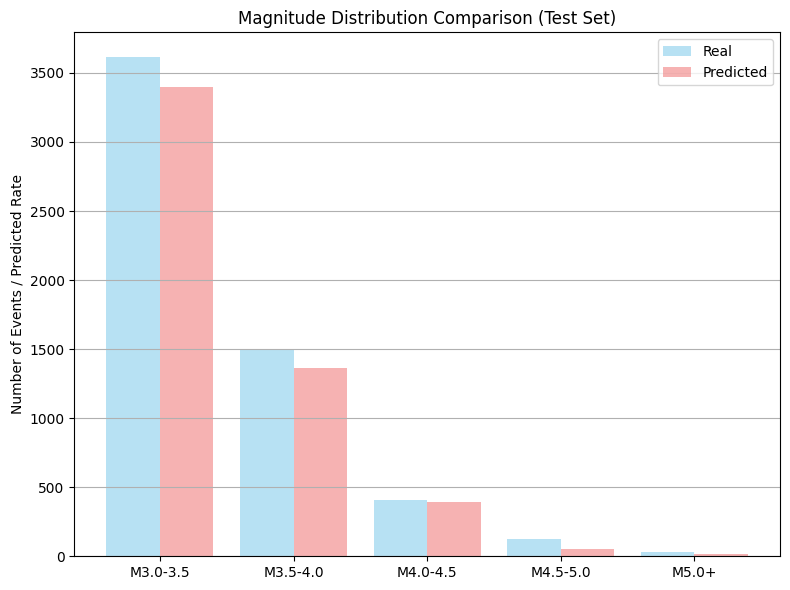


Plotting mainshocks in the test set (starting from 2009-01-01):
Plotting results for Mainshock: 2010-04-04 22:40:42.359999 Mw 7.2


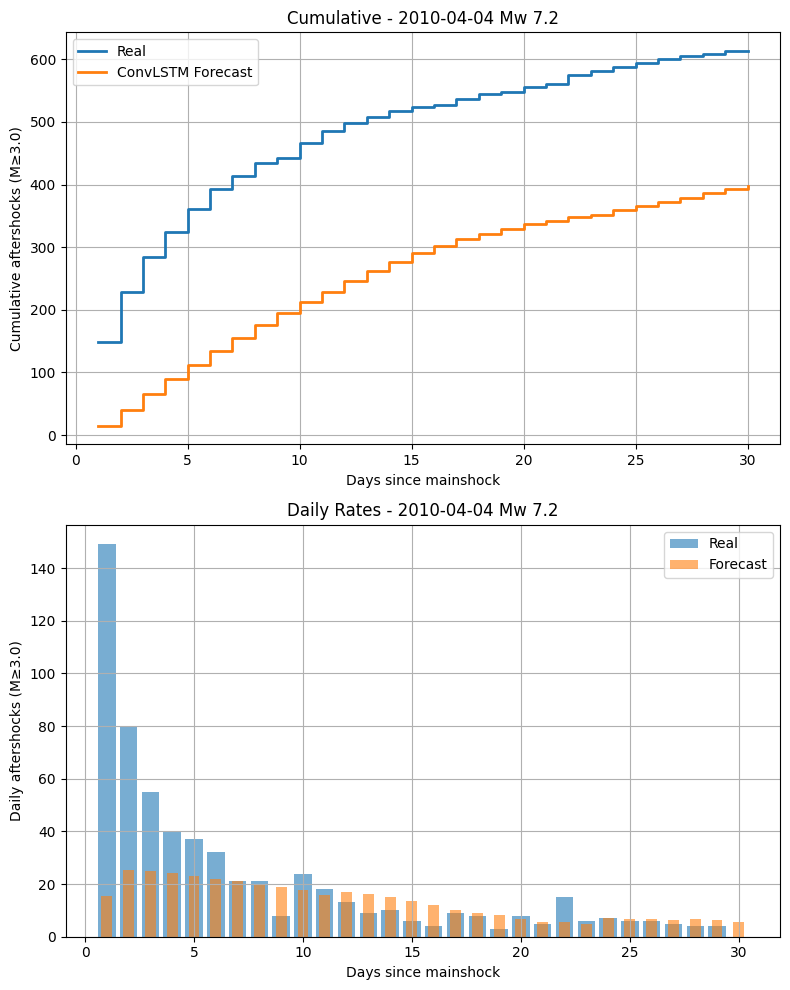

C:\Users\kma90\AppData\Local\Temp\ipykernel_23176\490174044.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(mag_bins) - 1)


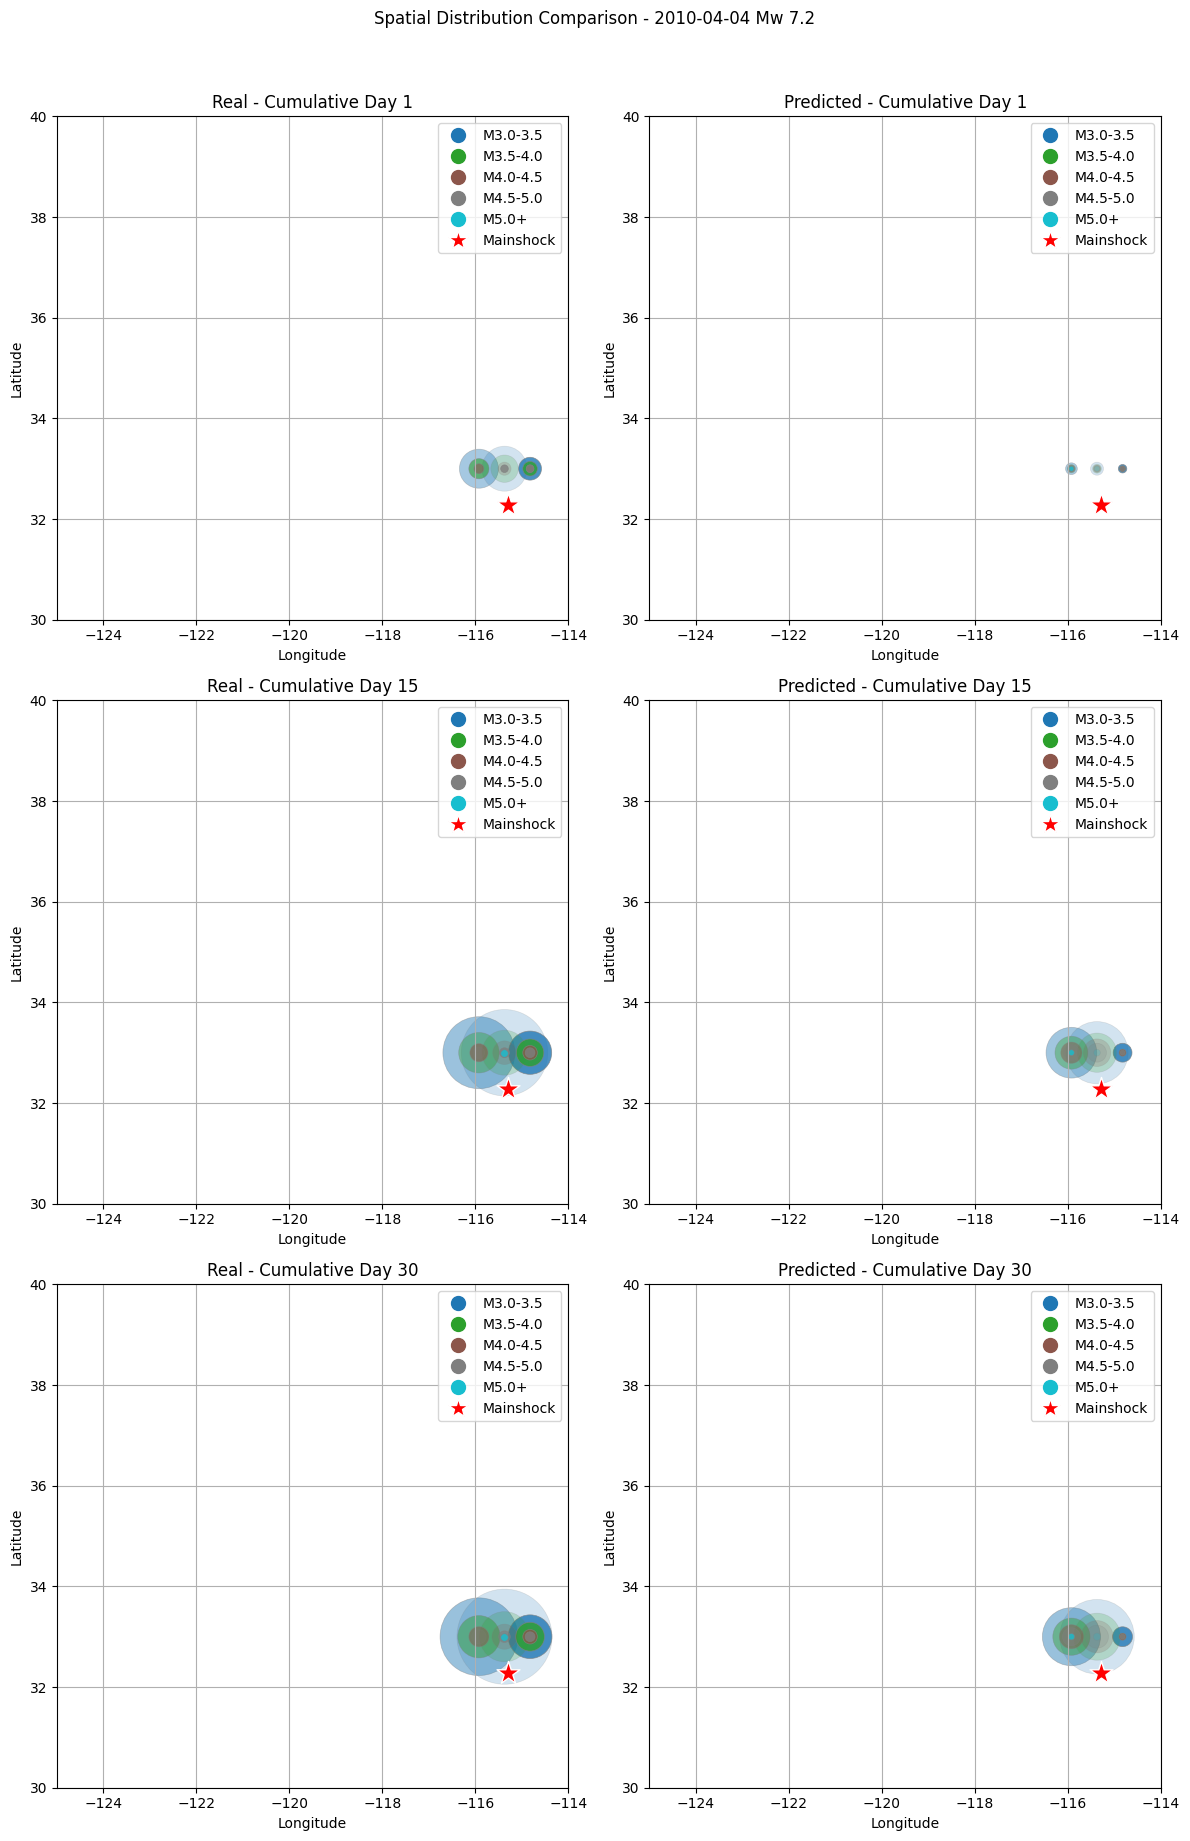

Plotting results for Mainshock: 2019-07-06 03:19:53.039999 Mw 7.1


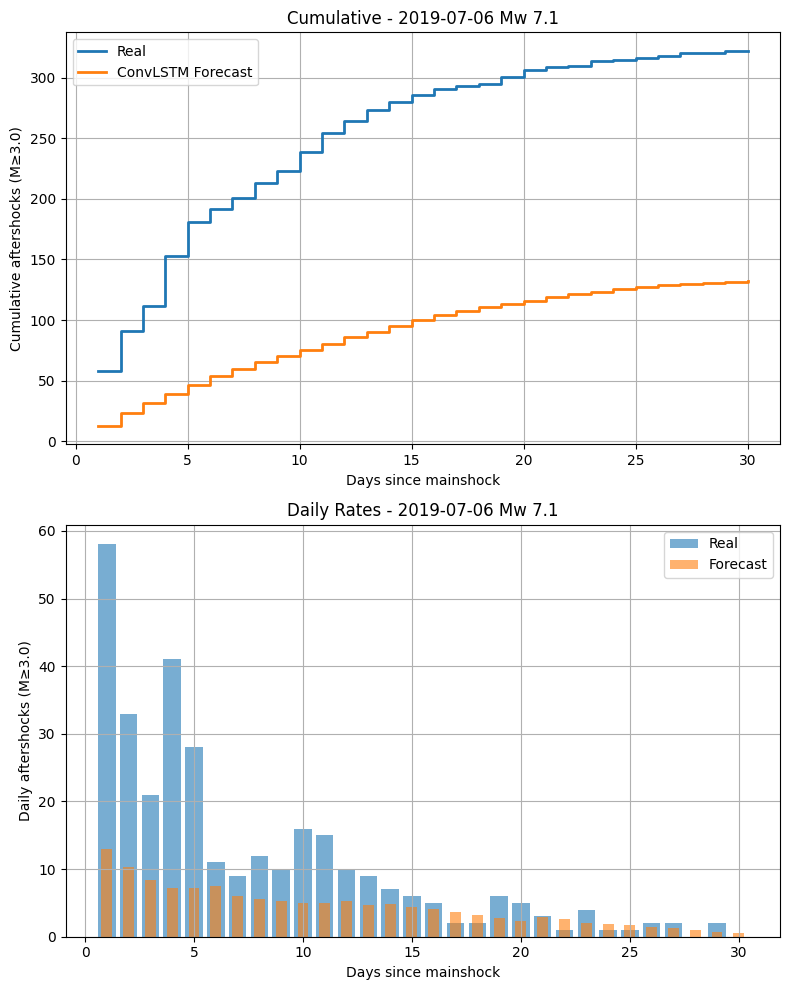

C:\Users\kma90\AppData\Local\Temp\ipykernel_23176\490174044.py:233: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(mag_bins) - 1)


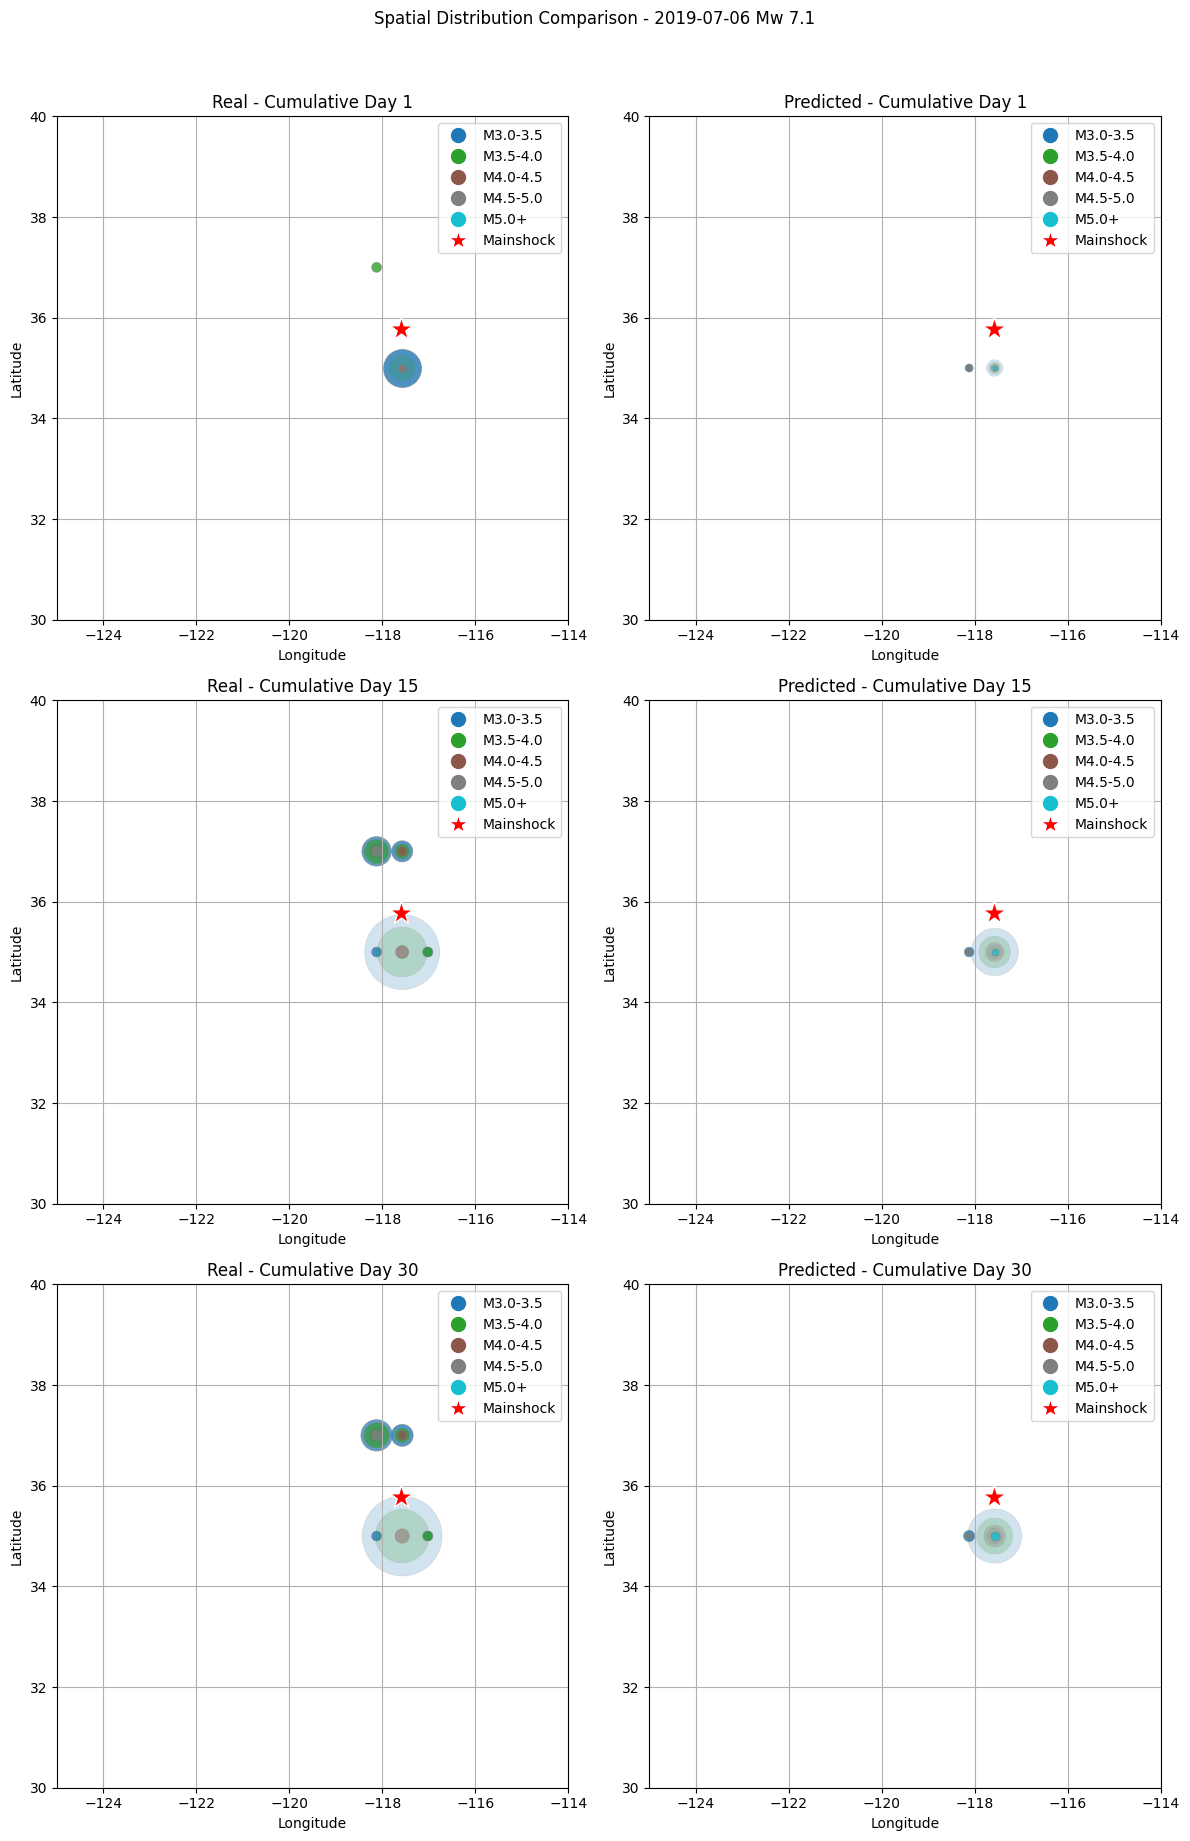

In [2]:
import numpy.ma as ma # Import masked array for correlation

# ---------------------------------------------------------------------------
# 4. Visualization utilities
# ---------------------------------------------------------------------------

def haversine_vec(lat1, lon1, lats, lons):
    """Vectorized Haversine distance (lat1/lon1 are scalars, lats/lons are arrays)."""
    R = 6371.0
    lat1, lon1 = np.radians([lat1, lon1])
    lats = np.radians(lats)
    lons = np.radians(lons)
    dlat = lats - lat1
    dlon = lons - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lats)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def evaluate_mainshock(mainshock_row, proc, model, device='cpu',
                       radius_km=100, days_window=30, min_mag=3.0):
    """
    Returns daily real and predicted aftershocks counts for a single mainshock
    within a specified radius and time window.
    """
    ms_time = pd.to_datetime(mainshock_row['time'])
    ms_lat = mainshock_row['latitude']
    ms_lon = mainshock_row['longitude']

    # Real aftershocks
    catalog = proc.df # Use the full catalog from the preprocessor
    mask = (catalog['time'] > ms_time) & \
           (catalog['time'] <= ms_time + pd.Timedelta(days=days_window)) & \
           (catalog['magnitude'] >= min_mag)
    after = catalog[mask].copy()
    after['dist'] = haversine_vec(ms_lat, ms_lon, after['latitude'].values, after['longitude'].values)
    after = after[after['dist'] <= radius_km]
    after['day'] = (after['time'] - ms_time).dt.days
    real_daily = after.groupby('day').size().reindex(range(1,days_window+1), fill_value=0).values

    # Predicted aftershocks (total count within radius)
    seq_len = proc.seq_len
    cubes = proc.daily_cubes # Use the full set of daily cubes
    pred_daily = []
    with torch.no_grad():
        for d in range(1, days_window+1):
            tgt_date = (ms_time + pd.Timedelta(days=d)).floor('d')
            seq_dates = [tgt_date - pd.Timedelta(days=seq) for seq in range(seq_len,0,-1)]
            if not all(date in cubes for date in seq_dates):
                pred_daily.append(0)
                continue
            x = np.stack([cubes[dt] for dt in seq_dates], axis=0)
            x = torch.from_numpy(x).unsqueeze(0).float().to(device)
            lam = model(x).cpu().squeeze(0).numpy() # Shape (mag_bins, lat_bins, lon_bins)

            count = 0
            for mi in range(len(proc.mag_bins)-1):
                for la in range(len(proc.lat_bins)-1):
                    for lo in range(len(proc.lon_bins)-1):
                        lat_center = (proc.lat_bins[la] + proc.lat_bins[la+1]) / 2
                        lon_center = (proc.lon_bins[lo] + proc.lon_bins[lo+1]) / 2
                        # Check if the center of the grid cell is within the radius
                        if haversine_vec(ms_lat, ms_lon, np.array([lat_center]), np.array([lon_center])) <= radius_km:
                            count += lam[mi, la, lo] # Summing predicted counts within radius across all mag bins
            pred_daily.append(count)

    return np.array(real_daily), np.array(pred_daily)


def plot_mainshock(mainshock_row, proc, model, device='cpu',
                   radius_km=100, days_window=30, min_mag=3.0):
    """Plot daily and cumulative aftershock comparisons for one mainshock."""

    real_daily, pred_daily = evaluate_mainshock(mainshock_row, proc, model, device, radius_km, days_window, min_mag)
    real_cum = np.cumsum(real_daily)
    pred_cum = np.cumsum(pred_daily)

    ms_time = pd.to_datetime(mainshock_row['time'])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,10))

    # Cumulative plot
    ax1.step(range(1, len(real_cum)+1), real_cum, where='post', label='Real', lw=2)
    ax1.step(range(1, len(pred_cum)+1), pred_cum, where='post', label='ConvLSTM Forecast', lw=2)
    ax1.set_xlabel('Days since mainshock')
    ax1.set_ylabel(f'Cumulative aftershocks (M\u2265{min_mag:.1f})')
    ax1.set_title(f"Cumulative - {ms_time.date()} Mw {mainshock_row['magnitude']:.1f}")
    ax1.grid(True)
    ax1.legend()

    # Daily rate plot
    ax2.bar(range(1,len(real_daily)+1), real_daily, width=0.8, alpha=0.6, label='Real')
    ax2.bar(range(1,len(pred_daily)+1), pred_daily, width=0.5, alpha=0.6, label='Forecast')
    ax2.set_xlabel('Days since mainshock')
    ax2.set_ylabel(f'Daily aftershocks (M\u2265{min_mag:.1f})')
    ax2.set_title(f"Daily Rates - {ms_time.date()} Mw {mainshock_row['magnitude']:.1f}")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()


def get_spatial_distribution_by_magnitude_cumulative(mainshock_row, proc, model, device='cpu',
                                                     radius_km=100, days_windows=[1, 15, 30], min_mag=3.0):
    """
    Returns cumulative real and predicted aftershock spatial distributions by magnitude bin
    for a single mainshock within a specified radius and multiple time windows.

    Args:
        mainshock_row (pd.Series): Row of the mainshock event from the catalog.
        proc (EarthquakePreprocessor): The preprocessor object.
        model (ConvLSTM): The trained ConvLSTM model.
        device (torch.device): Device to run the model on.
        radius_km (float): Radius around the mainshock to consider aftershocks.
        days_windows (list): List of cumulative days windows to consider (e.g., [1, 15, 30]).
        min_mag (float): Minimum magnitude for aftershocks.

    Returns:
        tuple: A tuple containing two dictionaries:
               - real_spatial_mag_cum: Dict with (magnitude bin index, cumulative day window) as key,
                                       and a spatial cube (lat_bins-1, lon_bins-1) as value.
               - pred_spatial_mag_cum: Dict with (magnitude bin index, cumulative day window) as key,
                                       and a spatial cube (lat_bins-1, lon_bins-1) as value.
    """
    ms_time = pd.to_datetime(mainshock_row['time'])
    ms_lat = mainshock_row['latitude']
    ms_lon = mainshock_row['longitude']

    max_days_window = max(days_windows)

    # Real aftershocks spatial distribution by magnitude
    catalog = proc.df # Use the full catalog from the preprocessor
    mask = (catalog['time'] > ms_time) & \
           (catalog['time'] <= ms_time + pd.Timedelta(days=max_days_window)) & \
           (catalog['magnitude'] >= min_mag)
    after = catalog[mask].copy()
    after['dist'] = haversine_vec(ms_lat, ms_lon, after['latitude'].values, after['longitude'].values)
    after = after[after['dist'] <= radius_km]
    after['day'] = (after['time'] - ms_time).dt.days

    # Create daily real spatial cubes per magnitude bin
    real_daily_spatial_mag = {i: [] for i in range(len(proc.mag_bins)-1)}
    for d in range(1, max_days_window + 1):
        day_after = after[after['day'] == d]
        day_cube = np.zeros((len(proc.mag_bins)-1, len(proc.lat_bins)-1, len(proc.lon_bins)-1), dtype=np.float32)
        if not day_after.empty:
            m = np.clip(np.digitize(day_after['magnitude'], proc.mag_bins)-1, 0, len(proc.mag_bins)-2)
            la = np.clip(np.digitize(day_after['latitude'], proc.lat_bins)-1, 0, len(proc.lat_bins)-2)
            lo = np.clip(np.digitize(day_after['longitude'], proc.lon_bins)-1, 0, len(proc.lon_bins)-2)
            for mi, lati, loni in zip(m, la, lo):
                 day_cube[mi, lati, loni] += 1
        for mi in range(len(proc.mag_bins)-1):
             real_daily_spatial_mag[mi].append(day_cube[mi, :, :])


    # Predicted aftershocks spatial distribution by magnitude
    seq_len = proc.seq_len
    cubes = proc.daily_cubes # Use the full set of daily cubes
    pred_daily_spatial_mag = {i: [] for i in range(len(proc.mag_bins)-1)}

    with torch.no_grad():
        for d in range(1, max_days_window+1):
            tgt_date = (ms_time + pd.Timedelta(days=d)).floor('d')
            seq_dates = [tgt_date - pd.Timedelta(days=seq) for seq in range(seq_len,0,-1)]

            daily_pred_cube = np.zeros((len(proc.mag_bins)-1, len(proc.lat_bins)-1, len(proc.lon_bins)-1), dtype=np.float32)

            if all(date in cubes for date in seq_dates):
                x = np.stack([cubes[dt] for dt in seq_dates], axis=0)
                x = torch.from_numpy(x).unsqueeze(0).float().to(device)
                lam = model(x).cpu().squeeze(0).numpy() # Shape (mag_bins, lat_bins, lon_bins)

                for mi in range(len(proc.mag_bins)-1):
                     for la in range(len(proc.lat_bins)-1):
                         for lo in range(len(proc.lon_bins)-1):
                             lat_center = (proc.lat_bins[la] + proc.lat_bins[la+1]) / 2
                             lon_center = (proc.lon_bins[lo] + proc.lon_bins[lo+1]) / 2
                             if haversine_vec(ms_lat, ms_lon, np.array([lat_center]), np.array([lon_center])) <= radius_km:
                                 daily_pred_cube[mi, la, lo] = lam[mi, la, lo]

            for mi in range(len(proc.mag_bins)-1):
                 pred_daily_spatial_mag[mi].append(daily_pred_cube[mi, :, :])

    # Cumulate daily spatial cubes for specified windows
    real_spatial_mag_cum = {}
    pred_spatial_mag_cum = {}

    for d in days_windows:
        if d <= max_days_window:
            for mi in range(len(proc.mag_bins)-1):
                # Ensure we don't try to sum empty lists if days_window is smaller than d
                if len(real_daily_spatial_mag[mi]) >= d:
                     real_spatial_mag_cum[(mi, d)] = np.sum(np.stack(real_daily_spatial_mag[mi][:d], axis=0), axis=0)
                else:
                     real_spatial_mag_cum[(mi, d)] = np.zeros((len(proc.lat_bins)-1, len(proc.lon_bins)-1))

                if len(pred_daily_spatial_mag[mi]) >= d:
                    pred_spatial_mag_cum[(mi, d)] = np.sum(np.stack(pred_daily_spatial_mag[mi][:d], axis=0), axis=0)
                else:
                    pred_spatial_mag_cum[(mi, d)] = np.zeros((len(proc.lat_bins)-1, len(proc.lon_bins)-1))


    return real_spatial_mag_cum, pred_spatial_mag_cum


def plot_spatial_distributions_combined(mainshock_row, proc,
                                        real_spatial_mag_cum, pred_spatial_mag_cum, days_windows=[1, 15, 30]):
    """
    Plots the real and predicted cumulative spatial distributions for all magnitude bins
    on a single spatial grid for specified time windows using scatter plots with colors.

    Args:
        mainshock_row (pd.Series): Row of the mainshock event.
        proc (EarthquakePreprocessor): The preprocessor object.
        real_spatial_mag_cum (dict): Cumulative real spatial cubes by (magnitude bin index, cumulative day window).
        pred_spatial_mag_cum (dict): Cumulative predicted spatial cubes by (magnitude bin index, cumulative day window).
        days_windows (list): List of cumulative days windows to plot.
    """
    ms_time = pd.to_datetime(mainshock_row['time'])
    mag_bins = proc.mag_bins
    lat_bins = proc.lat_bins
    lon_bins = proc.lon_bins

    # Define grid centers for plotting
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2
    grid_lon, grid_lat = np.meshgrid(lon_centers, lat_centers)

    num_time_windows = len(days_windows)
    fig, axes = plt.subplots(num_time_windows, 2, figsize=(12, num_time_windows * 6), squeeze=False)
    fig.suptitle(f"Spatial Distribution Comparison - {ms_time.date()} Mw {mainshock_row['magnitude']:.1f}", y=1.02)

    # Use a distinct color for each magnitude bin
    colors = plt.cm.get_cmap('tab10', len(mag_bins) - 1)

    for i, day_window in enumerate(days_windows):
        # Plot Real Data
        ax = axes[i, 0]
        ax.set_title(f"Real - Cumulative Day {day_window}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.scatter(mainshock_row['longitude'], mainshock_row['latitude'], color='red', marker='*', s=300, label='Mainshock', edgecolors='white', zorder=5) # zorder to ensure it's on top

        # Plot aftershock counts for each magnitude bin
        legend_handles = []
        for mag_bin_idx in range(len(mag_bins)-1):
            real_data = real_spatial_mag_cum.get((mag_bin_idx, day_window), np.zeros((len(lat_bins)-1, len(lon_bins)-1)))
            mag_label = f"M{mag_bins[mag_bin_idx]:.1f}-{mag_bins[mag_bin_idx+1]:.1f}" if mag_bins[mag_bin_idx+1] != np.inf else f"M{mag_bins[mag_bin_idx]:.1f}+"

            # Plot non-zero counts
            lat_indices, lon_indices = np.where(real_data > 0)
            counts = real_data[lat_indices, lon_indices]

            # Scale alpha: smaller counts are less transparent (higher alpha)
            # Normalize counts to a range [0, 1] and then map to an alpha range [alpha_min, alpha_max]
            # Invert the scaling so larger counts have lower alpha (more transparent)
            if len(counts) > 0:
                min_count = np.min(counts)
                max_count = np.max(counts)
                # Define the alpha range (e.g., from 0.2 for largest to 0.8 for smallest)
                alpha_min, alpha_max = 0.2, 0.8
                if max_count > min_count:
                    # Inverted linear scaling: alpha = alpha_max - (alpha_max - alpha_min) * (count - min_count) / (max_count - min_count)
                    alphas = alpha_max - (alpha_max - alpha_min) * (counts - min_count) / (max_count - min_count)
                else: # All counts are the same
                    alphas = np.full_like(counts, alpha_max) # Or some other default alpha

                # Use color based on magnitude bin
                ax.scatter(grid_lon[lat_indices, lon_indices], grid_lat[lat_indices, lon_indices],
                           c=[colors(mag_bin_idx)] * len(lat_indices), marker='o', # Using 'o' marker for all, color for distinction
                           s=counts * 20 + 10, alpha=alphas, edgecolors='grey', linewidth=0.5) # Size and alpha based on count

            # Create a legend handle for this magnitude bin
            legend_handles.append(mlines.Line2D([], [], color=colors(mag_bin_idx), marker='o', linestyle='None',
                                               markersize=10, label=mag_label))

        # Add mainshock handle to the legend
        mainshock_handle = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                                         markersize=15, label='Mainshock', markeredgecolor='white')
        legend_handles.append(mainshock_handle)

        ax.legend(handles=legend_handles)
        ax.set_xlim([lon_bins[0], lon_bins[-1]])
        ax.set_ylim([lat_bins[0], lat_bins[-1]])
        ax.grid(True)


        # Plot Predicted Data
        ax = axes[i, 1]
        ax.set_title(f"Predicted - Cumulative Day {day_window}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.scatter(mainshock_row['longitude'], mainshock_row['latitude'], color='red', marker='*', s=300, label='Mainshock', edgecolors='white', zorder=5) # zorder to ensure it's on top

        # Plot predicted counts for each magnitude bin
        legend_handles = [] # Reset legend handles for the predicted plot
        for mag_bin_idx in range(len(mag_bins)-1):
            pred_data = pred_spatial_mag_cum.get((mag_bin_idx, day_window), np.zeros((len(lat_bins)-1, len(lon_bins)-1)))
            mag_label = f"M{mag_bins[mag_bin_idx]:.1f}-{mag_bins[mag_bin_idx+1]:.1f}" if mag_bins[mag_bin_idx+1] != np.inf else f"M{mag_bins[mag_bin_idx]:.1f}+"

            # Plot non-zero counts (using predicted lambda values as size)
            lat_indices, lon_indices = np.where(pred_data > 0)
            counts = pred_data[lat_indices, lon_indices]

            # Scale alpha: smaller counts are less transparent (higher alpha)
            if len(counts) > 0:
                min_count = np.min(counts)
                max_count = np.max(counts)
                alpha_min, alpha_max = 0.2, 0.8 # Define the alpha range
                if max_count > min_count:
                     # Inverted linear scaling
                    alphas = alpha_max - (alpha_max - alpha_min) * (counts - min_count) / (max_count - min_count)
                else: # All counts are the same
                    alphas = np.full_like(counts, alpha_max)

                # Use color based on magnitude bin
                ax.scatter(grid_lon[lat_indices, lon_indices], grid_lat[lat_indices, lon_indices],
                           c=[colors(mag_bin_idx)] * len(lat_indices), marker='o', # Using 'o' marker for all, color for distinction
                           s=counts * 20 + 10, alpha=alphas, edgecolors='grey', linewidth=0.5) # Size and alpha based on count

            # Create a legend handle for this magnitude bin
            legend_handles.append(mlines.Line2D([], [], color=colors(mag_bin_idx), marker='o', linestyle='None',
                                               markersize=10, label=mag_label))

        # Add mainshock handle to the legend
        mainshock_handle = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                                         markersize=15, label='Mainshock', markeredgecolor='white')
        legend_handles.append(mainshock_handle)


        ax.legend(handles=legend_handles)
        ax.set_xlim([lon_bins[0], lon_bins[-1]])
        ax.set_ylim([lat_bins[0], lat_bins[-1]])
        ax.grid(True)


    plt.tight_layout()
    plt.show()


def plot_all_mainshocks(proc, model, device='cpu', radius_km=100, days_window=30, min_mag=3.0, test_mainshocks_only=True):
    """
    Finds and plots daily/cumulative aftershock counts and combined spatial distributions
    for all Mw>=7 mainshocks, optionally filtering for those in the test set.
    """
    # Find mainshocks with magnitude >= 7.0
    mains = proc.df[proc.df['magnitude'] >= 7]

    if test_mainshocks_only:
        # Filter mainshocks to include only those occurring in the test set period
        test_start_date = pd.Timestamp(TEST_CUTOFF)
        mains = mains[mains['time'] >= test_start_date]
        print(f"\nPlotting mainshocks in the test set (starting from {TEST_CUTOFF}):")
    else:
         print(f"\nPlotting all mainshocks (M>=7.0) in the catalog:")


    for idx, row in mains.iterrows():
        print(f"Plotting results for Mainshock: {row['time']} Mw {row['magnitude']:.1f}")

        # Plot daily and cumulative counts
        plot_mainshock(row, proc, model, device=device, radius_km=radius_km, days_window=days_window, min_mag=min_mag)

        # Get cumulative spatial data for specified days and magnitude bins
        real_spatial_mag_cum, pred_spatial_mag_cum = get_spatial_distribution_by_magnitude_cumulative(
            row, proc, model, device=device, radius_km=radius_km, days_windows=[1, 15, 30], min_mag=min_mag
        )

        # Plot combined spatial distributions
        plot_spatial_distributions_combined(row, proc, real_spatial_mag_cum, pred_spatial_mag_cum, days_windows=[1, 15, 30])

# # Example Usage (after training the model):
# # Assuming 'proc' and 'model' are already defined and the model is trained
# # plot_all_mainshocks(proc, model, device=DEVICE, test_mainshocks_only=True) # Plot only test set mainshocks
# # plot_all_mainshocks(proc, model, device=DEVICE, test_mainshocks_only=False) # Plot all major mainshocks

# ---------------------------------------------------------------------------
# 5. CSEP-like Metrics Calculation and Plotting
# ---------------------------------------------------------------------------

def calculate_total_events(model, dataloader, device):
    """
    Calculates the total number of real and predicted events in a dataset.

    Args:
        model (nn.Module): The trained ConvLSTM model.
        dataloader (DataLoader): DataLoader for the dataset (e.g., test_dl).
        device (torch.device): Device to run the model on.

    Returns:
        tuple: (total_real_events, total_predicted_events)
    """
    model.eval()
    total_real_events = 0
    total_predicted_events = 0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            lam = model(x).cpu().numpy() # Get predicted rates

            total_real_events += y.sum().item() # Sum real counts in the batch
            total_predicted_events += lam.sum().item() # Sum predicted rates in the batch

    return total_real_events, total_predicted_events

def calculate_spatial_correlation(model, dataloader, device):
    """
    Calculates the spatial correlation between real and predicted event distributions.
    Sums counts/rates over time and magnitude bins to get spatial distributions.

    Args:
        model (nn.Module): The trained ConvLSTM model.
        dataloader (DataLoader): DataLoader for the dataset (e.g., test_dl).
        device (torch.device): Device to run the model on.

    Returns:
        float: Spatial correlation coefficient. Returns NaN if no events in real data.
    """
    model.eval()
    # Initialize spatial grids (sum over mag and time)
    # Shape: (lat_bins-1, lon_bins-1)
    spatial_real_sum = None
    spatial_pred_sum = None

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            lam = model(x).cpu().numpy() # Shape (batch, mag_bins, lat_bins, lon_bins)
            y_np = y.numpy() # Shape (batch, mag_bins, lat_bins, lon_bins)

            # Sum over batch and magnitude dimensions for each sample
            batch_spatial_real = np.sum(y_np, axis=(0, 1)) # Shape (lat_bins, lon_bins)
            batch_spatial_pred = np.sum(lam, axis=(0, 1)) # Shape (lat_bins, lon_bins)

            if spatial_real_sum is None:
                spatial_real_sum = batch_spatial_real
                spatial_pred_sum = batch_spatial_pred
            else:
                spatial_real_sum += batch_spatial_real
                spatial_pred_sum += batch_spatial_pred

    if spatial_real_sum is None or np.sum(spatial_real_sum) == 0:
        print("Warning: No real events found in the dataset for spatial correlation calculation.")
        return np.nan # Return NaN if there are no real events to correlate against

    # Flatten the spatial grids for correlation calculation
    spatial_real_flat = spatial_real_sum.flatten()
    spatial_pred_flat = spatial_pred_sum.flatten()

    # Calculate Pearson correlation coefficient
    # Use numpy.ma.corrcoef to handle potential NaNs or constant arrays
    corr_matrix = ma.corrcoef(ma.masked_invalid(spatial_real_flat), ma.masked_invalid(spatial_pred_flat))

    # The correlation coefficient is the off-diagonal element
    if corr_matrix.shape == (2, 2):
         return corr_matrix[0, 1]
    elif corr_matrix.shape == (1, 1):
         # This happens if one of the arrays is constant (e.g., all zeros)
         # Correlation is undefined, return NaN
         return np.nan
    else:
         # Should not happen with two arrays, but as a safeguard
         return np.nan


def plot_magnitude_distribution(model, dataloader, mag_bins, device):
    """
    Plots the real and predicted cumulative magnitude distribution in a dataset.

    Args:
        model (nn.Module): The trained ConvLSTM model.
        dataloader (DataLoader): DataLoader for the dataset (e.g., test_dl).
        mag_bins (list): List of magnitude bin edges.
        device (torch.device): Device to run the model on.
    """
    model.eval()
    # Initialize magnitude distribution counts/rates
    # Shape: (mag_bins-1,)
    mag_real_counts = np.zeros(len(mag_bins) - 1)
    mag_pred_rates = np.zeros(len(mag_bins) - 1)

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            lam = model(x).cpu().numpy() # Shape (batch, mag_bins, lat_bins, lon_bins)
            y_np = y.numpy() # Shape (batch, mag_bins, lat_bins, lon_bins)

            # Sum over batch, latitude, and longitude dimensions for each magnitude bin
            batch_mag_real = np.sum(y_np, axis=(0, 2, 3)) # Shape (mag_bins,)
            batch_mag_pred = np.sum(lam, axis=(0, 2, 3)) # Shape (mag_bins,)

            mag_real_counts += batch_mag_real
            mag_pred_rates += batch_mag_pred

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    mag_labels = [f"M{mag_bins[i]:.1f}-{mag_bins[i+1]:.1f}" if mag_bins[i+1] != np.inf else f"M{mag_bins[i]:.1f}+" for i in range(len(mag_bins)-1)]
    x_pos = np.arange(len(mag_labels))

    ax.bar(x_pos - 0.2, mag_real_counts, width=0.4, alpha=0.6, label='Real', color='skyblue')
    ax.bar(x_pos + 0.2, mag_pred_rates, width=0.4, alpha=0.6, label='Predicted', color='lightcoral')

    ax.set_ylabel('Number of Events / Predicted Rate')
    ax.set_title('Magnitude Distribution Comparison (Test Set)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(mag_labels)
    ax.legend()
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()



def calculate_and_plot_spatial_log_likelihood(model, dataloader, lat_bins, lon_bins, device, eps=1e-6):
    """
    Calculates the Poisson log-likelihood for each spatial bin across the dataset
    and plots the distribution. Also returns the total log-likelihood.

    Args:
        model (nn.Module): The trained ConvLSTM model.
        dataloader (DataLoader): DataLoader for the dataset (e.g., test_dl).
        lat_bins (list): List of latitude bin edges.
        lon_bins (list): List of longitude bin edges.
        device (torch.device): Device to run the model on.
        eps (float): Small value to prevent log(0).

    Returns:
        float: Total Poisson log-likelihood for the dataset.
    """
    model.eval()
    # Initialize spatial log-likelihood grid
    # Shape: (lat_bins-1, lon_bins-1)
    spatial_log_likelihood_sum = np.zeros((len(lat_bins) - 1, len(lon_bins) - 1))
    total_log_likelihood = 0.0

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            lam = model(x) # Shape (batch, mag_bins, lat_bins, lon_bins)
            y = y.to(device) # Shape (batch, mag_bins, lat_bins, lon_bins)

            # Calculate log-likelihood for each element in the batch
            # log P(Y=y | lambda) = sum(y * log(lambda) - lambda - log(y!))
            # We are calculating the negative log-likelihood in the loss, so we'll sum that.
            # Sum over magnitude and time (batch) for each spatial bin
            batch_log_likelihood = (y * torch.log(lam + eps) - lam).sum(dim=(0, 1)).cpu().numpy() # Sum over batch and magnitude

            spatial_log_likelihood_sum += batch_log_likelihood
            total_log_likelihood += (y * torch.log(lam + eps) - lam).sum().item() # Sum over all dimensions for total

    # Plotting spatial log-likelihood
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Define grid centers for plotting
    lon_centers = (lon_bins[:-1] + lon_bins[1:]) / 2
    lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2

    # Create a heatmap of the spatial log-likelihood
    # Use pcolormesh for gridded data
    # We need to adjust the extent to match the bin edges
    im = ax.pcolormesh(lon_bins, lat_bins, spatial_log_likelihood_sum, shading='flat', cmap='viridis')
    fig.colorbar(im, ax=ax, label='Total Log-Likelihood per Spatial Bin')

    ax.set_title('Spatial Distribution of Total Log-Likelihood (Test Set)')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim([lon_bins[0], lon_bins[-1]])
    ax.set_ylim([lat_bins[0], lat_bins[-1]])
    ax.set_aspect('equal', adjustable='box') # Keep aspect ratio
    ax.grid(True, color='white', linestyle='-', linewidth=0.5)

    plt.tight_layout()
    plt.show()

    return total_log_likelihood


# he best model for evaluation on the test set
if os.path.exists('best_convlstm.pt'): # Check if the best model was saved
    model.load_state_dict(torch.load('best_convlstm.pt'))
    model.eval() # Set model to evaluation mode
    print("\nEvaluating on the test set:")

    test_loss = eval_epoch(model, test_dl, DEVICE)
    print(f"Poisson Loss on Test Set: {test_loss:.4f}")

    # Calculate CSEP-like metrics on the test set
    total_real_events, total_predicted_events = calculate_total_events(model, test_dl, DEVICE)
    print(f"Total Real Events (Test Set): {total_real_events}")
    print(f"Total Predicted Events (Test Set): {total_predicted_events:.2f}")

    spatial_corr = calculate_spatial_correlation(model, test_dl, DEVICE)
    print(f"Spatial Correlation (Test Set): {spatial_corr:.4f}")



    print("\nMagnitude Distribution (Test Set):")
    plot_magnitude_distribution(model, test_dl, proc.mag_bins, DEVICE)

    # Visualize major mainshocks in the test set
    plot_all_mainshocks(proc, model, device=DEVICE, test_mainshocks_only=True)

else:
    print("\nNo best model checkpoint found. Skipping test evaluation and visualization.")
